### Honor Track: experience replay

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week3_model_free/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144556 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [3]:
#<YOUR CODE: copy your implementation of QLearningAgent from previous notebooks here>
from collections import defaultdict
import random
import math
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value=-10000000000000000
        for action in possible_actions:
          value=max(value,self.get_qvalue(state,action))
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        q=(1-learning_rate)*self.get_qvalue(state,action)+learning_rate*(reward+gamma*self.get_value(next_state))

        self.set_qvalue(state, action, q)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        best_action=possible_actions[0]
        m=-10000000000000000000000000000
        for action in possible_actions:
          curr=self.get_qvalue(state,action)
          if curr>m:
            m=curr
            best_action=action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        chosen_action="c"
        nr=np.random.rand()
        if nr<epsilon:
          chosen_action=np.random.choice(possible_actions)
        else:
          chosen_action=self.get_best_action(state)

        return chosen_action

In [10]:
import random


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        self._storage.append(data)
        if len(self._storage)>self._maxsize:
          self._storage.pop(0)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = np.random.randint(len(self._storage),size=batch_size)#<YOUR CODE: randomly generate batch_size integers to be used as indexes of samples>

        # collect <s,a,r,s',done> for each index
        data=[self._storage[index] for index in idxes]
        states=[el[0] for el in data]
        actions=[el[1] for el in data]
        rew=[el[2] for el in data]
        next_s=[el[3] for el in data]
        done=[el[4] for el in data]

        return (
            np.array( states ),
            np.array( actions ),
            np.array( rew ),
            np.array( next_s ),
            np.array( done)
        )

Some tests to make sure your buffer works right

In [11]:
def obj2arrays(obj):
    for x in obj:
        yield np.array([x])

def obj2sampled(obj):
    return tuple(obj2arrays(obj))

replay = ReplayBuffer(2)
obj1 = (0, 1, 2, 3, True)
obj2 = (4, 5, 6, 7, False)
replay.add(*obj1)
assert replay.sample(1) == obj2sampled(obj1), \
    "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj2)
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj1)
print("Success!")

Success!


Now let's use this buffer to improve training:

In [12]:
import gym

try:
    env = gym.make('Taxi-v3')
except gym.error.DeprecatedEnv:
    # Taxi-v2 was replaced with Taxi-v3 in gym 0.15.0
    env = gym.make('Taxi-v2')

n_actions = env.action_space.n

In [19]:
def play_and_train_with_replay(env, agent, replay=None,
                               t_max=10**4, replay_batch_size=32):
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update
        agent.update(s,a,r,next_s)

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            replay.add(s,a,r,next_s,done)

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            s_, a_, r_, next_s_, done_ = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                agent.update(s_[i],a_[i],r_[i],next_s_[i])

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [20]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

agent_replay = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 7.4
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 6.8


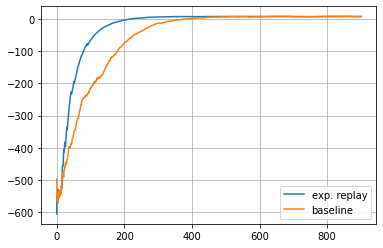

In [21]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(
        play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(
        play_and_train_with_replay(env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()

### Submit to Coursera

In [22]:
from submit import submit_experience_replay
submit_experience_replay(rewards_replay, rewards_baseline, 'andrei.saceleanu@stud.acs.upb.ro', '6Vj5Sn1KUtlD4ZMm')

Submitted to Coursera platform. See results on assignment page!


#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.

### Outro

We will use the code you just wrote extensively in the next week of our course. If you're feeling that you need more examples to understand how experience replay works, try using it for binarized state spaces (CartPole or other __[classic control envs](https://gym.openai.com/envs/#classic_control)__).

__Next week__ we're gonna explore how q-learning and similar algorithms can be applied for large state spaces, with deep learning models to approximate the Q function.

However, __the code you've written__ for this week is already capable of solving many RL problems, and as an added benifit - it is very easy to detach. You can use Q-learning, SARSA and Experience Replay for any RL problems you want to solve - just thow 'em into a file and import the stuff you need.